In [9]:
# Quandl for historical stock prices and data,
# fbprophet for additive models, far better than any model I could ever make 
import pandas as pd
import numpy as np
import fbprophet

# matplotlib pyplot for plotting
import matplotlib.pyplot as plt

import matplotlib

End Date exceeds data range
Enter a new end date1990-01-01
Start Date is before date range
Enter a new start date1992-01-01
End Date must be later than start date.
Enter a new start date1986-01-01
Enter a new end date2011-01-01
Start Date is before date range
Enter a new start date1990-01-01
Maximum Adj. Close = 39.65 on 1999-12-27.
Minimum Adj. Close = 0.40 on 1990-01-12.
Current Adj. Close = 91.61 on 2018-01-22.



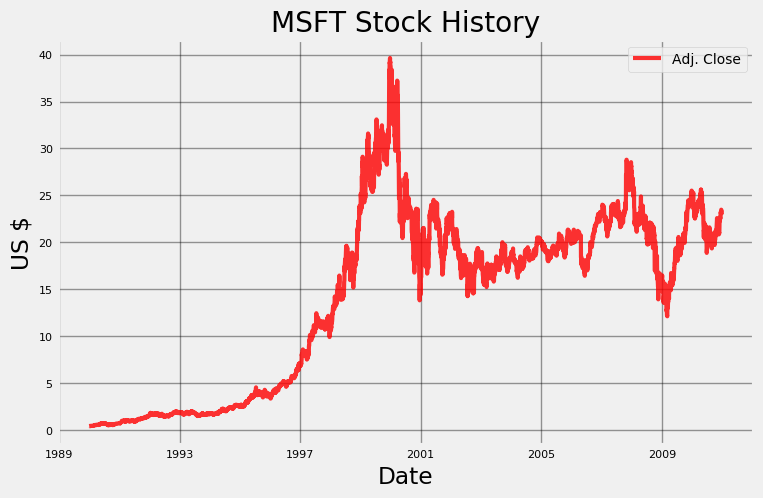

In [47]:
micro.plot_stock(start_date='1980-02-10', end_date='2019-01-01')

In [35]:
micro.stock.ix[len(micro.stock) - 1, 'Adj. Close']

91.609999999999999

In [19]:
import quandl
import pandas as pd
import numpy as np
import fbprophet
import pytrends
from pytrends.request import TrendReq

import matplotlib.pyplot as plt

import matplotlib

#this is gonna be so rough I need to make a class to contain all this shit
class Stock():
    
    # Initialization requires a ticker symbol
    def __init__(self, ticker):
        
        
        ticker = ticker.upper()
        
        
        self.symbol = ticker
        
        

        
        stock = quandl.get('WIKI/%s' % ticker)
        

        
        # Set the index to a column called Date
        stock = stock.reset_index(level=0)
        
        # Columns required for prophet
        stock['ds'] = stock['Date']
        stock['y'] = stock['Adj. Close']
        stock['Daily Change'] = stock['Adj. Close'] - stock['Adj. Open']
        
        # Data assigned as class attribute
        self.stock = stock.copy()
        self.min_date = min(stock['Date'])
        self.max_date = max(stock['Date'])
        
        self.max_price = np.max(self.stock['y'])
        self.min_price = np.min(self.stock['y'])
        self.min_price_date = self.stock[self.stock['y'] == self.min_price]['Date']
        self.min_price_date = self.min_price_date[self.min_price_date.index[0]]
        self.max_price_date = self.stock[self.stock['y'] == self.max_price]['Date']
        self.max_price_date = self.max_price_date[self.max_price_date.index[0]]
        
       
        self.starting_price = float(self.stock.ix[0, 'Adj. Open'])
        
   
        self.most_recent_price = float(self.stock.ix[len(self.stock) - 1, 'y'])

        # Whether or not to round dates
        self.round_dates = True
        
        # Number of years of data to train on
        self.training_years = 6

        # Prophet parameters
        # Default prior from library
        self.changepoint_prior_scale = 0.05 
        self.weekly_seasonality = False
        self.daily_seasonality = False
        self.monthly_seasonality = True
        self.yearly_seasonality = True
        self.changepoints = None
        
        print('{} Stock Initialized. Data covers {} to {}.'.format(self.symbol,
                                                                     self.min_date.date(),
                                                                     self.max_date.date()))
    def handle_dates(self, starting_date, ending_date):
        
        
        # Default start and end date are the beginning and end of data
        if starting_date is None:
            starting_date = self.min_date
        if ending_date is None:
            ending_date = self.max_date
        
#         try:
            # Convert to pandas datetime for indexing dataframe
            starting_date = pd.to_datetime(starting_date)
            ending_date = pd.to_datetime(ending_date)
        
#         except Exception as e:
#             print('Enter valid pandas date format.')
#             print(e)
#             return
        
        valid_start = False
        valid_end = False
        
        # User will continue to enter dates until valid dates are met
        while (not valid_start) & (not valid_end):
            valid_end = True
            valid_start = True
            
            if ending_date.date() < starting_date.date():
                print('End Date must be later than start date.')
                starting_date = pd.to_datetime(input('Enter a new start date: '))
                ending_date= pd.to_datetime(input('Enter a new end date: '))
                valid_end = False
                valid_start = False
            
            else: 
                if ending_date.date() > self.max_date.date():
                    print('End Date exceeds data range')
                    ending_date= pd.to_datetime(input('Enter a new end date: '))
                    valid_end = False

                if starting_date.date() < self.min_date.date():
                    print('Start Date is before date range')
                    starting_date = pd.to_datetime(input('Enter a new start date: '))
                    valid_start = False
                
        
        return starting_date, ending_date
        
    """
    Return the dataframe trimmed to the specified range.
    """
    def make_df(self, starting_date, ending_date, df=None):
        
        # Default is to use the object stock data
        if not df:
            df = self.stock.copy()
        
        
        starting_date, ending_date = self.handle_dates(starting_date, ending_date)
        
        # keep track of whether the start and end dates are in the data
        start_in = True
        end_in = True

        # If user wants to round dates (default behavior)
        if self.round_dates:
            # Record if start and end date are in df
            if (starting_date not in list(df['Date'])):
                start_in = False
            if (ending_date not in list(df['Date'])):
                end_in = False

            # If both are not in dataframe, round both
            if (not end_in) & (not start_in):
                trim_df = df[(df['Date'] >= starting_date.date()) & 
                             (df['Date'] <= ending_date.date())]
            
            else:
                # If both are in dataframe, round neither
                if (end_in) & (start_in):
                    trim_df = df[(df['Date'] >= starting_date.date()) & 
                                 (df['Date'] <= ending_date.date())]
                else:
                    # If only start is missing, round start
                    if (not start_in):
                        trim_df = df[(df['Date'] > starting_date.date()) & 
                                     (df['Date'] <= ending_date.date())]
                    # If only end is imssing round end
                    elif (not end_in):
                        trim_df = df[(df['Date'] >= starting_date.date()) & 
                                     (df['Date'] < ending_date.date())]

        
        else:
            valid_start = False
            valid_end = False
            while (not valid_start) & (not valid_end):
                starting_date, ending_date = self.handle_dates(starting_date, ending_date)
                
                # No round dates, if either data not in, print message and return
                if (starting_date in list(df['Date'])):
                    valid_start = True
                if (ending_date in list(df['Date'])):
                    valid_end = True
                    
                # Check to make sure dates are in the data
                if (starting_date not in list(df['Date'])):
                    print('Start Date not in data (either out of range or not a trading day.)')
                    starting_date = pd.to_datetime(input(prompt='Enter a new start date: '))
                    
                elif (ending_date not in list(df['Date'])):
                    print('End Date not in data (either out of range or not a trading day.)')
                    ending_date = pd.to_datetime(input(prompt='Enter a new end date: ') )

            # Dates are not rounded
            trim_df = df[(df['Date'] >= starting_date.date()) & 
                         (df['Date'] <= ending_date.date())]

        
            
        return trim_df


    # Basic Historical Plots and Basic Statistics
    def plot_stock(self, starting_date=None, ending_date=None, stats=['Adj. Close'], plot_type='basic'):
        
        self.reset_plot()
        
        if starting_date is None:
            starting_date = self.min_date
        if ending_date is None:
            ending_date = self.max_date
        
        stock_plot = self.make_df(starting_date, ending_date)

        colors = ['r', 'b', 'g', 'y', 'c', 'm']
        
        for i, stat in enumerate(stats):
            
            stat_min = min(stock_plot[stat])
            stat_max = max(stock_plot[stat])

            stat_avg = np.mean(stock_plot[stat])
            
            date_stat_min = stock_plot[stock_plot[stat] == stat_min]['Date']
            date_stat_min = date_stat_min[date_stat_min.index[0]].date()
            date_stat_max = stock_plot[stock_plot[stat] == stat_max]['Date']
            date_stat_max = date_stat_max[date_stat_max.index[0]].date()
            
            print('Maximum {} = {:.2f} on {}.'.format(stat, stat_max, date_stat_max))
            print('Minimum {} = {:.2f} on {}.'.format(stat, stat_min, date_stat_min))
            print('Current {} = {:.2f} on {}.\n'.format(stat, self.stock.ix[len(self.stock) - 1, stat], self.max_date.date()))
            
            # Percentage y-axis
            if plot_type == 'pct':
                # Simple Plot 
                plt.style.use('fivethirtyeight');
                if stat == 'Daily Change':
                    plt.plot(stock_plot['Date'], 100 * stock_plot[stat],
                         color = colors[i], linewidth = 2.4, alpha = 0.9,
                         label = stat)
                else:
                    plt.plot(stock_plot['Date'], 100 * (stock_plot[stat] -  stat_avg) / stat_avg,
                         color = colors[i], linewidth = 2.4, alpha = 0.9,
                         label = stat)

                plt.xlabel('Date'); plt.ylabel('Change Relative to Average (%)'); plt.title('%s Stock History' % self.symbol); 
                plt.legend(prop={'size':10})
                plt.grid(color = 'k', alpha = 0.4); 

            # Stat y-axis
            elif plot_type == 'basic':
                plt.style.use('fivethirtyeight');
                plt.plot(stock_plot['Date'], stock_plot[stat], color = colors[i], linewidth = 3, label = stat, alpha = 0.8)
                plt.xlabel('Date'); plt.ylabel('US $'); plt.title('%s Stock History' % self.symbol); 
                plt.legend(prop={'size':10})
                plt.grid(color = 'k', alpha = 0.4); 
      
        plt.show();
        
    # Reset the plotting parameters to clear style formatting
    # Not sure if this should be a static method
    @staticmethod
    def reset_plot():
        
        # Restore default parameters
        matplotlib.rcParams.update(matplotlib.rcParamsDefault)
        
        # Adjust a few parameters to liking
        matplotlib.rcParams['figure.figsize'] = (8, 5)
        matplotlib.rcParams['axes.labelsize'] = 10
        matplotlib.rcParams['xtick.labelsize'] = 8
        matplotlib.rcParams['ytick.labelsize'] = 8
        matplotlib.rcParams['axes.titlesize'] = 14
        matplotlib.rcParams['text.color'] = 'k'
    
    # Method to linearly interpolate prices on the weekends
    def resample(self, dataframe):
        # Change the index and resample at daily level
        dataframe = dataframe.set_index('ds')
        dataframe = dataframe.resample('D')
        
        # Reset the index and interpolate nan values
        dataframe = dataframe.reset_index(level=0)
        dataframe = dataframe.interpolate()
        return dataframe
    
    # Remove weekends from a dataframe
    def remove_weekends(self, dataframe):
        
        # Reset index to use ix
        dataframe = dataframe.reset_index(drop=True)
        
        weekends = []
        
        # Find all of the weekends
        for i, date in enumerate(dataframe['ds']):
            if (date.weekday()) == 5 | (date.weekday() == 6):
                weekends.append(i)
            
        # Drop the weekends
        dataframe = dataframe.drop(weekends, axis=0)
        
        return dataframe
    
    
    # Calculate and plot profit from buying and holding shares for specified date range
    def buy_and_hold(self, starting_date=None, ending_date=None, nshares=1):
        self.reset_plot()
        
        starting_date, ending_date = self.handle_dates(starting_date, ending_date)
            
        # Find starting and ending price of stock
        start_price = float(self.stock[self.stock['Date'] == starting_date]['Adj. Open'])
        end_price = float(self.stock[self.stock['Date'] == ending_date]['Adj. Close'])
        
        # Make a profit dataframe and calculate profit column
        profits = self.make_df(starting_date, ending_date)
        profits['hold_profit'] = nshares * (profits['Adj. Close'] - start_price)
        
        # Total profit
        total_hold_profit = nshares * (end_price - start_price)
        
        print('{} Total buy and hold profit from {} to {} for {} shares = ${:.2f}'.format
              (self.symbol, starting_date.date(), ending_date.date(), nshares, total_hold_profit))
        
        # Plot the total profits 
        plt.style.use('dark_background')
        
        # Location for number of profit
        text_location = (ending_date - pd.DateOffset(months = 1)).date()
        
        # Plot the profits over time
        plt.plot(profits['Date'], profits['hold_profit'], 'b', linewidth = 3)
        plt.ylabel('Profit ($)'); plt.xlabel('Date'); plt.title('Buy and Hold Profits for {} {} to {}'.format(
                                                                self.symbol, starting_date.date(), ending_date.date()))
        
        # Display final value on graph
        plt.text(x = text_location, 
             y =  total_hold_profit + (total_hold_profit / 40),
             s = '$%d' % total_hold_profit,
            color = 'g' if total_hold_profit > 0 else 'r',
            size = 14)
        
        plt.grid(alpha=0.2)
        plt.show();
        
    # Create a prophet model without training
    def create_model(self):

        # Make the model
        model = fbprophet.Prophet(daily_seasonality=self.daily_seasonality,  
                                  weekly_seasonality=self.weekly_seasonality, 
                                  yearly_seasonality=self.yearly_seasonality,
                                  changepoint_prior_scale=self.changepoint_prior_scale,
                                  changepoints=self.changepoints)
        
        if self.monthly_seasonality:
            # Add monthly seasonality
            model.add_seasonality(name = 'monthly', period = 30.5, fourier_order = 5)
        
        return model
    
    # Graph the effects of altering the changepoint prior scale (cps)
    def changepoint_prior_analysis(self, changepoint_priors=[0.001, 0.05, 0.1, 0.2], colors=['b', 'r', 'grey', 'gold']):
    
        # Training and plotting with specified years of data
        train = self.stock[(self.stock['Date'] > (max(self.stock['Date']) - pd.DateOffset(years=self.training_years)).date())]
        
        # Iterate through all the changepoints and make models
        for i, prior in enumerate(changepoint_priors):
            # Select the changepoint
            self.changepoint_prior_scale = prior
            
            # Create and train a model with the specified cps
            model = self.create_model()
            model.fit(train)
            future = model.make_future_dataframe(periods=180, freq='D')
            
            # Make a dataframe to hold predictions
            if i == 0:
                predictions = future.copy()
                
            future = model.predict(future)
            
            # Fill in prediction dataframe
            predictions['%.3f_yhat_upper' % prior] = future['yhat_upper']
            predictions['%.3f_yhat_lower' % prior] = future['yhat_lower']
            predictions['%.3f_yhat' % prior] = future['yhat']
         
        # Remove the weekends
        predictions = self.remove_weekends(predictions)
        
        # Plot set-up
        self.reset_plot()
        plt.style.use('fivethirtyeight')
        fig, ax = plt.subplots(1, 1)
        
        # Actual observations
        ax.plot(train['ds'], train['y'], 'ko', ms = 4, label = 'Observations')
        color_dict = {prior: color for prior, color in zip(changepoint_priors, colors)}

        # Plot each of the changepoint predictions
        for prior in changepoint_priors:
            # Plot the predictions themselves
            ax.plot(predictions['ds'], predictions['%.3f_yhat' % prior], linewidth = 1.2,
                     color = color_dict[prior], label = '%.3f prior scale' % prior)
            
            # Plot the uncertainty interval
            ax.fill_between(predictions['ds'].dt.to_pydatetime(), predictions['%.3f_yhat_upper' % prior],
                            predictions['%.3f_yhat_lower' % prior], facecolor = color_dict[prior],
                            alpha = 0.3, edgecolor = 'k', linewidth = 0.6)
                            
        # Plot labels
        plt.legend(loc = 2, prop={'size': 10})
        plt.xlabel('Date'); plt.ylabel('Stock Price ($)'); plt.title('Effect of Changepoint Prior Scale');
        plt.show()
            
    # Basic prophet model for specified number of days  
    def create_prophet_model(self, days=0, resample=False):
        
        self.reset_plot()
        
        model = self.create_model()
        
        # Fit on the stock history for self.training_years number of years
        stock_history = self.stock[self.stock['Date'] > (self.max_date - pd.DateOffset(years = self.training_years)).date()]
        
        if resample:
            stock_history = self.resample(stock_history)
        
        model.fit(stock_history)
        
        # Make and predict for next year with future dataframe
        future = model.make_future_dataframe(periods = days, freq='D')
        future = model.predict(future)
        
        if days > 0:
            # Print the predicted price
            print('Predicted Price on {} = ${:.2f}'.format(
                future.ix[len(future) - 1, 'ds'].date(), future.ix[len(future) - 1, 'yhat']))

            title = '%s Historical and Predicted Stock Price'  % self.symbol
        else:
            title = '%s Historical and Modeled Stock Price' % self.symbol
        
       
        fig, ax = plt.subplots(1, 1)
        # Plot the actual values
        ax.plot(stock_history['ds'], stock_history['y'], 'ko-', linewidth = 1.4, alpha = 0.8, ms = 1.8, label = 'Observations')
        
        # Plot the predicted values
        ax.plot(future['ds'], future['yhat'], 'forestgreen',linewidth = 2.4, label = 'Modeled');
        ax.fill_between(future['ds'].dt.to_pydatetime(), future['yhat_upper'], future['yhat_lower'], alpha = 0.3, 
                       facecolor = 'g', edgecolor = 'k', linewidth = 1.4, label = 'Confidence Interval')

        # Plot formatting
        plt.legend(loc = 2, prop={'size': 10}); plt.xlabel('Date'); plt.ylabel('Price $');
        plt.grid(linewidth=0.6, alpha = 0.6)
        plt.title(title);
        plt.show()
        
        return model, future
      
    # Evaluate prediction model for one year
    def evaluate_prediction(self, starting_date=None, ending_date=None, nshares = None):
        
        # Default start date is one year before end of data
        # Default end date is end date of data
        if starting_date is None:
            starting_date = self.max_date - pd.DateOffset(years=1)
        if ending_date is None:
            ending_date = self.max_date
            
        starting_date, ending_date = self.handle_dates(starting_date, ending_date)
        
        # Training data starts self.training_years years before start date and goes up to start date
        train = self.stock[(self.stock['Date'] < starting_date.date()) & 
                           (self.stock['Date'] > (starting_date - pd.DateOffset(years=self.training_years)).date())]
        
        # Testing data is specified in the range
        test = self.stock[(self.stock['Date'] >= starting_date.date()) & (self.stock['Date'] <= ending_date.date())]
        
        # Create and train the model
        model = self.create_model()
        model.fit(train)
        
        # Make a future dataframe and predictions
        future = model.make_future_dataframe(periods = 365, freq='D')
        future = model.predict(future)
        
        # Merge predictions with the known values
        test = pd.merge(test, future, on = 'ds', how = 'inner')

        train = pd.merge(train, future, on = 'ds', how = 'inner')
        
        # Calculate the differences between consecutive measurements
        test['pred_diff'] = test['yhat'].diff()
        test['real_diff'] = test['y'].diff()
        
        # Correct is when we predicted the correct direction
        test['correct'] = (np.sign(test['pred_diff']) == np.sign(test['real_diff'])) * 1
        
        # Accuracy when we predict increase and decrease
        increase_accuracy = 100 * np.mean(test[test['pred_diff'] > 0]['correct'])
        decrease_accuracy = 100 * np.mean(test[test['pred_diff'] < 0]['correct'])

        # Calculate mean absolute error
        test_errors = abs(test['y'] - test['yhat'])
        test_mean_error = np.mean(test_errors)

        train_errors = abs(train['y'] - train['yhat'])
        train_mean_error = np.mean(train_errors)

        # Calculate percentage of time actual value within prediction range
        test['in_range'] = False

        for i in test.index:
            if (test.ix[i, 'y'] < test.ix[i, 'yhat_upper']) & (test.ix[i, 'y'] > test.ix[i, 'yhat_lower']):
                test.ix[i, 'in_range'] = True

        in_range_accuracy = 100 * np.mean(test['in_range'])

        if not nshares:

            # Date range of predictions
            print('\nPrediction Range: {} to {}.'.format(starting_date.date(),
                ending_date.date()))

            # Final prediction vs actual value
            print('\nPredicted price on {} = ${:.2f}.'.format(max(future['ds']).date(), future.ix[len(future) - 1, 'yhat']))
            print('Actual price on    {} = ${:.2f}.\n'.format(max(test['ds']).date(), test.ix[len(test) - 1, 'y']))

            print('Average Absolute Error on Training Data = ${:.2f}.'.format(train_mean_error))
            print('Average Absolute Error on Testing  Data = ${:.2f}.\n'.format(test_mean_error))

            # Direction accuracy
            print('When the model predicted an increase, the price increased {:.2f}% of the time.'.format(increase_accuracy))
            print('When the model predicted a  decrease, the price decreased  {:.2f}% of the time.\n'.format(decrease_accuracy))

            print('The actual value was within the {:d}% confidence interval {:.2f}% of the time.'.format(int(100 * model.interval_width), in_range_accuracy))


             # Reset the plot
            self.reset_plot()
            
            # Set up the plot
            fig, ax = plt.subplots(1, 1)

            # Plot the actual values
            ax.plot(train['ds'], train['y'], 'ko-', linewidth = 1.4, alpha = 0.8, ms = 1.8, label = 'Observations')
            ax.plot(test['ds'], test['y'], 'ko-', linewidth = 1.4, alpha = 0.8, ms = 1.8, label = 'Observations')
            
            # Plot the predicted values
            ax.plot(future['ds'], future['yhat'], 'navy', linewidth = 2.4, label = 'Predicted');

            # Plot the uncertainty interval as ribbon
            ax.fill_between(future['ds'].dt.to_pydatetime(), future['yhat_upper'], future['yhat_lower'], alpha = 0.6, 
                           facecolor = 'gold', edgecolor = 'k', linewidth = 1.4, label = 'Confidence Interval')

            # Put a vertical line at the start of predictions
            plt.vlines(x=min(test['ds']).date(), ymin=min(future['yhat_lower']), ymax=max(future['yhat_upper']), colors = 'r',
                       linestyles='dashed', label = 'Prediction Start')

            # Plot formatting
            plt.legend(loc = 2, prop={'size': 8}); plt.xlabel('Date'); plt.ylabel('Price $');
            plt.grid(linewidth=0.6, alpha = 0.6)
                       
            plt.title('{} Model Evaluation from {} to {}.'.format(self.symbol,
                starting_date.date(), ending_date.date()));
            plt.show();

        
        # If a number of shares is specified, play the game
        elif nshares:
            
            # Only playing the stocks when we predict the stock will increase
            test_pred_increase = test[test['pred_diff'] > 0]
            
            test_pred_increase.reset_index(inplace=True)
            prediction_profit = []
            
            # Iterate through all the predictions and calculate profit from playing
            for i, correct in enumerate(test_pred_increase['correct']):
                
                # If we predicted up and the price goes up, we gain the difference
                if correct == 1:
                    prediction_profit.append(nshares * test_pred_increase.ix[i, 'real_diff'])
                # If we predicted up and the price goes down, we lose the difference
                else:
                    prediction_profit.append(nshares * test_pred_increase.ix[i, 'real_diff'])
            
            test_pred_increase['pred_profit'] = prediction_profit
            
            # Put the profit into the test dataframe
            test = pd.merge(test, test_pred_increase[['ds', 'pred_profit']], on = 'ds', how = 'left')
            test.ix[0, 'pred_profit'] = 0
        
            # Profit for either method at all dates
            test['pred_profit'] = test['pred_profit'].cumsum().ffill()
            test['hold_profit'] = nshares * (test['y'] - float(test.ix[0, 'y']))
            print('You played the stock market in {} from {} to {} with {} shares.\n'.format(
                self.symbol, starting_date.date(), ending_date.date(), nshares))
            
            print('When the model predicted an increase, the price increased {:.2f}% of the time.'.format(increase_accuracy))
            print('When the model predicted a  decrease, the price decreased  {:.2f}% of the time.\n'.format(decrease_accuracy))

            # Display some friendly information about the perils of playing the stock market
            print('The total profit using the Prophet model = ${:.2f}.'.format(np.sum(prediction_profit)))
            print('The Buy and Hold strategy profit =         ${:.2f}.'.format(float(test.ix[len(test) - 1, 'hold_profit'])))
            print('\nThanks for playing the stock market!\n')
            
           
            
            # Plot the predicted and actual profits over time
            self.reset_plot()
            
            # Final profit and final smart used for locating text
            final_profit = test.ix[len(test) - 1, 'pred_profit']
            final_smart = test.ix[len(test) - 1, 'hold_profit']

            # text location
            last_date = test.ix[len(test) - 1, 'ds']
            text_location = (last_date - pd.DateOffset(months = 1)).date()

            plt.style.use('dark_background')

            # Plot smart profits
            plt.plot(test['ds'], test['hold_profit'], 'b',
                     linewidth = 1.8, label = 'Buy and Hold Strategy') 

            # Plot prediction profits
            plt.plot(test['ds'], test['pred_profit'], 
                     color = 'g' if final_profit > 0 else 'r',
                     linewidth = 1.8, label = 'Prediction Strategy')

            # Display final values on graph
            plt.text(x = text_location, 
                     y =  final_profit + (final_profit / 40),
                     s = '$%d' % final_profit,
                    color = 'g' if final_profit > 0 else 'r',
                    size = 18)
            
            plt.text(x = text_location, 
                     y =  final_smart + (final_smart / 40),
                     s = '$%d' % final_smart,
                    color = 'g' if final_smart > 0 else 'r',
                    size = 18);

            # Plot formatting
            plt.ylabel('Profit  (US $)'); plt.xlabel('Date'); 
            plt.title('Predicted versus Buy and Hold Profits');
            plt.legend(loc = 2, prop={'size': 10});
            plt.grid(alpha=0.2); 
            plt.show()
        
    def retrieve_google_trends(self, search, date_range):
        
        # Set up the trend fetching object
        pytrends = TrendReq(hl='en-US', tz=360)
        kw_list = [search]

        try:
        
            # Create the search object
            pytrends.build_payload(kw_list, cat=0, timeframe=date_range[0], geo='', gprop='news')
            
            # Retrieve the interest over time
            trends = pytrends.interest_over_time()

            related_queries = pytrends.related_queries()

        except Exception as e:
            print('\nGoogle Search Trend retrieval failed.')
            print(e)
            return
        
        return trends, related_queries
        
 
        
    # Predict the future price for a given range of days
    def predict_future(self, days=30):
        
        # Use past self.training_years years for training
        train = self.stock[self.stock['Date'] > (max(self.stock['Date']) - pd.DateOffset(years=self.training_years)).date()]
        
        model = self.create_model()
        
        model.fit(train)
        
        # Future dataframe with specified number of days to predict
        future = model.make_future_dataframe(periods=days, freq='D')
        future = model.predict(future)
        
        # Only concerned with future dates
        future = future[future['ds'] >= max(self.stock['Date']).date()]
        
        # Remove the weekends
        future = self.remove_weekends(future)
        
        # Calculate whether increase or not
        future['diff'] = future['yhat'].diff()
    
        future = future.dropna()

        # Find the prediction direction and create separate dataframes
        future['direction'] = (future['diff'] > 0) * 1
        
        # Rename the columns for presentation
        future = future.rename(columns={'ds': 'Date', 'yhat': 'estimate', 'diff': 'change', 
                                        'yhat_upper': 'upper', 'yhat_lower': 'lower'})
        
        future_increase = future[future['direction'] == 1]
        future_decrease = future[future['direction'] == 0]
        
        # Print out the dates
        print('\nPredicted Increase: \n')
        print(future_increase[['Date', 'estimate', 'change', 'upper', 'lower']])
        
        print('\nPredicted Decrease: \n')
        print(future_decrease[['Date', 'estimate', 'change', 'upper', 'lower']])
        
        self.reset_plot()
        
        # Set up plot
        plt.style.use('fivethirtyeight')
        matplotlib.rcParams['axes.labelsize'] = 10
        matplotlib.rcParams['xtick.labelsize'] = 8
        matplotlib.rcParams['ytick.labelsize'] = 8
        matplotlib.rcParams['axes.titlesize'] = 12
        
        # Plot the predictions and indicate if increase or decrease
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))

        # Plot the estimates
        ax.plot(future_increase['Date'], future_increase['estimate'], 'g^', ms = 12, label = 'Pred. Increase')
        ax.plot(future_decrease['Date'], future_decrease['estimate'], 'rv', ms = 12, label = 'Pred. Decrease')

        # Plot errorbars
        ax.errorbar(future['Date'].dt.to_pydatetime(), future['estimate'], 
                    yerr = future['upper'] - future['lower'], 
                    capthick=1.4, color = 'k',linewidth = 2,
                   ecolor='darkblue', capsize = 4, elinewidth = 1, label = 'Pred with Range')

        # Plot formatting
        plt.legend(loc = 2, prop={'size': 10});
        plt.xticks(rotation = '45')
        plt.ylabel('Predicted Stock Price (US $)');
        plt.xlabel('Date'); plt.title('Predictions for %s' % self.symbol);
        plt.show()
        
    def changepoint_prior_validation(self, starting_date=None, ending_date=None,changepoint_priors = [0.001, 0.05, 0.1, 0.2]):


        # Default start date is two years before end of data
        # Default end date is one year before end of data
        if starting_date is None:
            starting_date = self.max_date - pd.DateOffset(years=2)
        if ending_date is None:
            ending_date = self.max_date - pd.DateOffset(years=1)
            
        # Convert to pandas datetime for indexing dataframe
        starting_date = pd.to_datetime(starting_date)
        ending_date = pd.to_datetime(ending_date)
        
        starting_date, ending_date = self.handle_dates(starting_date, ending_date)
                               
        # Select self.training_years number of years
        train = self.stock[(self.stock['Date'] > (starting_date - pd.DateOffset(years=self.training_years)).date()) & 
        (self.stock['Date'] < starting_date.date())]
        
        # Testing data is specified by range
        test = self.stock[(self.stock['Date'] >= starting_date.date()) & (self.stock['Date'] <= ending_date.date())]

        eval_days = (max(test['Date']).date() - min(test['Date']).date()).days
        
        results = pd.DataFrame(0, index = list(range(len(changepoint_priors))), 
            columns = ['cps', 'train_err', 'train_range', 'test_err', 'test_range'])

        print('\nValidation Range {} to {}.\n'.format(min(test['Date']).date(),
            max(test['Date']).date()))
            
        
        # Iterate through all the changepoints and make models
        for i, prior in enumerate(changepoint_priors):
            results.ix[i, 'cps'] = prior
            
            # Select the changepoint
            self.changepoint_prior_scale = prior
            
            # Create and train a model with the specified cps
            model = self.create_model()
            model.fit(train)
            future = model.make_future_dataframe(periods=eval_days, freq='D')
                
            future = model.predict(future)
            
            # Training results and metrics
            train_results = pd.merge(train, future[['ds', 'yhat', 'yhat_upper', 'yhat_lower']], on = 'ds', how = 'inner')
            avg_train_error = np.mean(abs(train_results['y'] - train_results['yhat']))
            avg_train_uncertainty = np.mean(abs(train_results['yhat_upper'] - train_results['yhat_lower']))
            
            results.ix[i, 'train_err'] = avg_train_error
            results.ix[i, 'train_range'] = avg_train_uncertainty
            
            # Testing results and metrics
            test_results = pd.merge(test, future[['ds', 'yhat', 'yhat_upper', 'yhat_lower']], on = 'ds', how = 'inner')
            avg_test_error = np.mean(abs(test_results['y'] - test_results['yhat']))
            avg_test_uncertainty = np.mean(abs(test_results['yhat_upper'] - test_results['yhat_lower']))
            
            results.ix[i, 'test_err'] = avg_test_error
            results.ix[i, 'test_range'] = avg_test_uncertainty

        print(results)


        
        # Plot of training and testing average errors
        self.reset_plot()
        
        plt.plot(results['cps'], results['train_err'], 'bo-', ms = 8, label = 'Train Error')
        plt.plot(results['cps'], results['test_err'], 'r*-', ms = 8, label = 'Test Error')
        plt.xlabel('Changepoint Prior Scale'); plt.ylabel('Avg. Absolute Error ($)');
        plt.title('Training and Testing Curves as Function of CPS')
        plt.grid(color='k', alpha=0.3)
        plt.xticks(results['cps'], results['cps'])
        plt.legend(prop={'size':10})
        plt.show();
        
        # Plot of training and testing average uncertainty
        self.reset_plot()

        plt.plot(results['cps'], results['train_range'], 'bo-', ms = 8, label = 'Train Range')
        plt.plot(results['cps'], results['test_range'], 'r*-', ms = 8, label = 'Test Range')
        plt.xlabel('Changepoint Prior Scale'); plt.ylabel('Avg. Uncertainty ($)');
        plt.title('Uncertainty in Estimate as Function of CPS')
        plt.grid(color='k', alpha=0.3)
        plt.xticks(results['cps'], results['cps'])
        plt.legend(prop={'size':10})
        plt.show();

In [25]:
msft = Stocker('MSFT')

MSFT Stocker Initialized. Data covers 1986-03-13 to 2018-03-27.


/Users/adamkrauss/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:65: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


/Users/adamkrauss/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):



Predicted Increase: 

          Date    estimate    change       upper       lower
2   2018-03-29   94.789664  0.066983   96.420460   93.112002
3   2018-03-30   95.093056  0.303392   96.773103   93.376637
5   2018-04-01   95.837097  0.744041   97.632478   94.129699
6   2018-04-02   95.848121  0.011025   97.536656   94.244474
9   2018-04-05   95.400264  0.020479   97.047995   93.687744
10  2018-04-06   95.708186  0.307921   97.408089   94.016441
12  2018-04-08   96.351746  0.643561   97.957632   94.560186
16  2018-04-12   96.339630  0.166057   98.062270   94.632466
17  2018-04-13   96.643050  0.303420   98.460450   94.947811
19  2018-04-15   97.078752  0.435702   98.744459   95.348995
20  2018-04-16   97.148238  0.069486   98.878628   95.546531
21  2018-04-17   97.231413  0.083175   98.906333   95.525883
22  2018-04-18   97.371818  0.140405   99.238919   95.712596
23  2018-04-19   97.512726  0.140908   99.393684   95.798729
24  2018-04-20   97.573778  0.061053   99.411652   95.908349
2

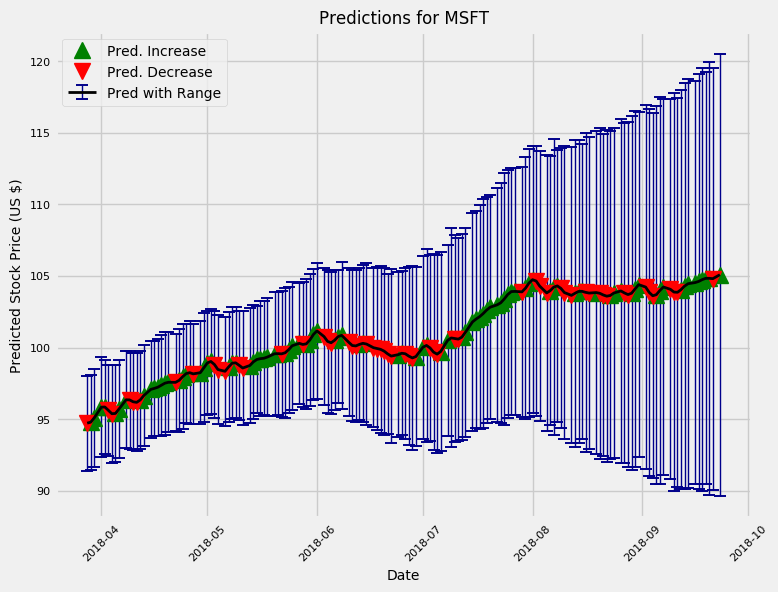

In [26]:
msft.predict_future(180)

Maximum Daily Change = 20.77 on 2014-01-14.
Minimum Daily Change = -27.95 on 2018-02-08.
Current Daily Change = -24.82 on 2018-03-27.



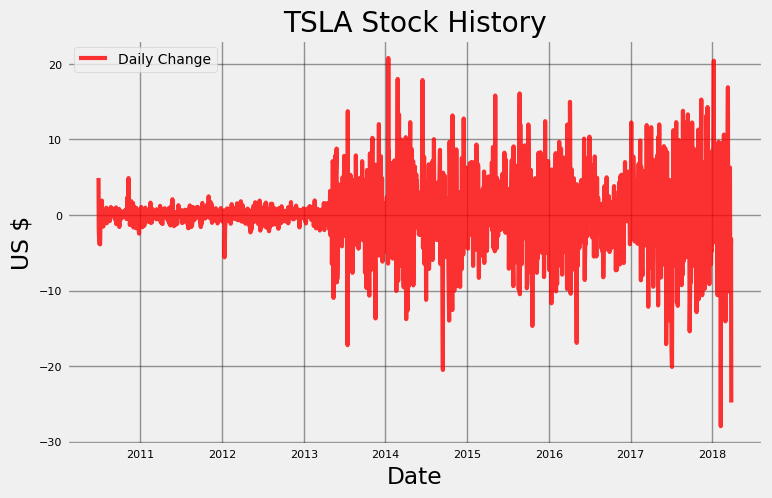

In [24]:
tesla.plot_stock(stats=['Daily Change'])

/Users/adamkrauss/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


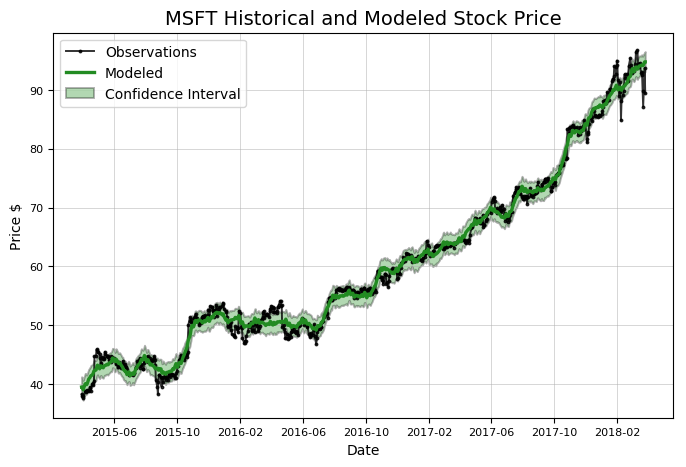

In [27]:
model, model_data = msft.create_prophet_model()

/Users/adamkrauss/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/Users/adamkrauss/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:534: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/Users/adamkrauss/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:546: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated



Prediction Range: 2017-03-27 to 2018-03-27.

Predicted price on 2018-03-24 = $428.32.
Actual price on    2018-03-23 = $301.54.

Average Absolute Error on Training Data = $12.41.
Average Absolute Error on Testing  Data = $33.12.

When the model predicted an increase, the price increased 45.96% of the time.
When the model predicted a  decrease, the price decreased  40.91% of the time.

The actual value was within the 80% confidence interval 57.20% of the time.


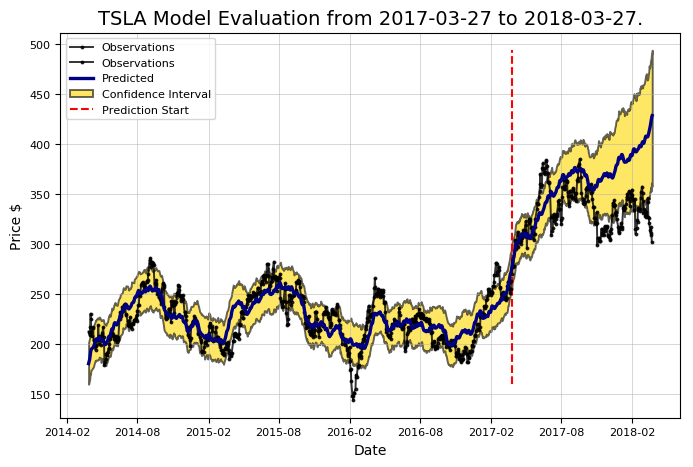

In [17]:
tesla.evaluate_prediction()